In [370]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.linear_model as linear_model 
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error as mae
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

In [193]:
train = pd.read_csv('data/train.csv', header=None, names=['Date', 'Point', 'Count'])

cities = train.Point.apply(lambda x: x.split('-')[0])
cities_set = cities.unique()
cities = cities.apply(lambda x: np.where(cities_set==x)[0][0])
train.insert(len(train.columns)-1, 'City', cities)


points_set = pd.Series(train.Point).unique()
train.Point = train.Point.apply(lambda x: np.where(points_set==x)[0][0])

train.Date = train.Date.apply(lambda x: pd.to_datetime(x))

week_day = train.Date.apply(lambda x: x.weekday())
month = train.Date.apply(lambda x: x.month + (x.year - 2000) * 12)
year = train.Date.apply(lambda x: x.year)
start_date = pd.to_datetime('1.1.2000')
week = train.Date.apply(lambda x: int((x - start_date).days / 7))
year_day = train.Date.apply(lambda x: (x-pd.to_datetime(str(x.year)+'-01-01')).days)
monthweek_day = train.Date.apply(lambda x: x.month * 7  + x.weekday())

train.insert(len(train.columns) - 1, 'WeekDay', week_day)
train.insert(len(train.columns) - 1, 'Month', month)
train.insert(len(train.columns) - 1, 'Year', year)
train.insert(len(train.columns) - 1, 'Week', week)
train.insert(len(train.columns) - 1, 'MonthWeekDay', monthweek_day)
train.insert(len(train.columns) - 1, 'YearDay', year_day)
train

,Date,Point,City,WeekDay,Month,Year,Week,MonthWeekDay,YearDay,Count
0,2016-08-08,0,0,0,200,2016,866,56,220,42
1,2015-07-03,1,1,4,187,2015,808,53,183,81
2,2016-05-10,2,2,1,197,2016,853,36,130,138
3,2015-02-22,3,3,6,182,2015,790,20,52,94
4,2016-06-08,4,4,2,198,2016,857,44,159,42
5,2016-09-28,5,5,2,201,2016,873,65,271,123
6,2016-09-13,6,6,1,201,2016,871,64,256,186
7,2016-01-29,7,7,4,193,2016,838,11,28,30
8,2016-08-17,8,8,2,200,2016,867,58,229,64
9,2013-08-23,9,7,4,164,2013,711,60,234,48


AttributeError: Unknown property freq

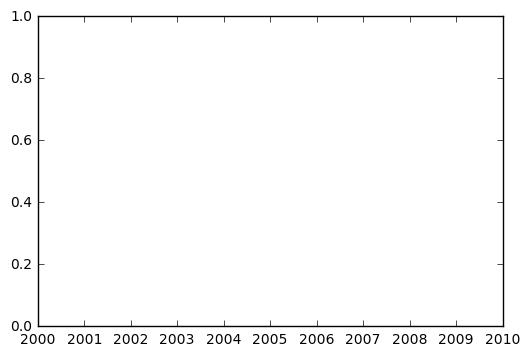

In [369]:
start_date = pd.to_datetime('2016-01-01')
sub_train = train[train.Date > start_date].sort_values(by=['Date'], axis=0)
to_plot = pd.DataFrame()
unique_city = sub_train.City.unique()

groupped = sub_train[sub_train.City == 1].groupby(['Date'])['Count']
_max = sub_train[sub_train.City == 1].Count.max() 
mean = groupped.mean().apply(lambda x: float(x) / _max)

arima_model = ARIMA(mean.as_matrix(), order=())
plt.plot(mean.axes[0], mean.as_matrix(), freq='D')

plt.gcf().autofmt_xdate()



Среднее за месяц, неделю, год, день недели


In [183]:
year_point_mean = train.groupby(['Year', 'Point'])['Count'].mean()
month_point_mean = train.groupby(['Month', 'Point'])['Count'].mean()
week_point_mean = train.groupby(['Week', 'Point'])['Count'].mean()
weekday_point_mean = train.groupby(['WeekDay', 'Point'])['Count'].mean()
monthweekday_point_mean = train.groupby(['MonthWeekDay', 'Point'])['Count'].mean()

train_mean = pd.DataFrame()

def get_year(x, p):
    return year_point_mean[x][p]
def get_month(x, p):
    return month_point_mean[x][p]
def get_week(x, p):
    return week_point_mean[x][p]
def get_weekday(x, p):
    return weekday_point_mean[x][p]
def get_monthweekday(x, p):
    return monthweekday_point_mean[x][p]
train_mean.insert(len(train_mean.columns), 'YearPoint', train[['Year', 'Point']].apply(lambda x: get_year(*x), axis=1))
train_mean.insert(len(train_mean.columns), 'MonthPoint', train[['Month', 'Point']].apply(lambda x: get_month(*x), axis=1))
train_mean.insert(len(train_mean.columns), 'WeekPoint', train[['Week', 'Point']].apply(lambda x: get_week(*x), axis=1))
train_mean.insert(len(train_mean.columns), 'WeekDayPoint', train[['WeekDay', 'Point']].apply(lambda x: get_weekday(*x), axis=1))
train_mean.insert(len(train_mean.columns), 'MonthWeekDayPoint', train[['MonthWeekDay', 'Point']].apply(lambda x: get_monthweekday(*x), axis=1))

train_mean.insert(len(train_mean.columns), 'Count', train.Count)
train_mean

,YearPoint,MonthPoint,WeekPoint,WeekDayPoint,MonthWeekDayPoint,Count
0,38.908046,47.050000,37.666667,33.090909,46.000000,42
1,57.756494,58.846154,65.333333,69.627119,76.900000,81
2,151.782101,153.130435,146.000000,114.108108,128.625000,138
3,85.664516,76.090909,66.800000,94.008264,94.909091,94
4,61.996094,55.807692,53.571429,51.060000,43.500000,42
5,124.260700,148.960000,162.833333,110.250000,105.428571,123
6,213.501946,238.120000,241.000000,144.691489,125.444444,186
7,40.214844,42.923077,37.166667,42.611111,47.833333,30
8,64.463035,69.153846,72.833333,54.826923,59.666667,64
9,40.279605,42.370370,51.142857,72.440191,79.450000,48


In [171]:
def trainModelTestTrainSplit(data, model):
    c = data.columns.difference(['Count'])
    X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(data[c], data['Count'], test_size=0.3, random_state=0)
    model.verbose=1
    model.fit(X_train.as_matrix(), y_train.as_matrix())
    pred = model.predict(X_test)
    #pred = map(round, pred)
    print ("result ", mae(pred, y_test))
    return model

def trainModelKfold(data, model, countFold = 5):
    meanMae = 0
    
    c = data.columns.difference(['Count'])
    countFold = 5
    kf = KFold(len(data), n_folds=countFold, shuffle=True)
    
    for train_index, test_index in kf:
        X_train, X_test = data[c].loc[train_index], data[c].loc[test_index]
        y_train, y_test = data['Count'].loc[train_index], data['Count'].loc[test_index]
        model.fit(X_train.as_matrix(), y_train.as_matrix())
        pred = model.predict(X_test)
        print (mae(pred, y_test))
        meanMae += mae(pred, y_test)
    meanMae /= countFold
    print ("result ", meanMae)
    return model

In [189]:
linear_regression = linear_model.LinearRegression(n_jobs = -1)
kf = trainModelKfold(train_mean, linear_regression)
tts = trainModelTestTrainSplit(train_mean[['WeekPoint', 'Count']], linear_regression)
print (kf.coef_, tts.coef_)


23.7219952494
24.4633035319
23.8756134716
24.2187119971
24.0040197942
result  24.0567288089
result  24.7993257084
[ 0.99625618] [ 0.99625618]


In [188]:
train_mean.corr()

,YearPoint,MonthPoint,WeekPoint,WeekDayPoint,MonthWeekDayPoint,Count
YearPoint,1.000000,0.965297,0.924771,0.826435,0.793343,0.786046
MonthPoint,0.965297,1.000000,0.957020,0.799404,0.800220,0.814305
WeekPoint,0.924771,0.957020,1.000000,0.769345,0.776220,0.850560
WeekDayPoint,0.826435,0.799404,0.769345,1.000000,0.941270,0.717462
MonthWeekDayPoint,0.793343,0.800220,0.776220,0.941270,1.000000,0.762228
Count,0.786046,0.814305,0.850560,0.717462,0.762228,1.000000
